In [47]:
import pandas as pd
import requests
from bs4 import BeautifulSoup
import yfinance as yf
import lxml
import numpy as np
import networkx as nx
import community.community_louvain as community_louvain
import matplotlib.pyplot as plt
from sklearn.cluster import SpectralClustering
from ripser import ripser
from persim import plot_diagrams

In [112]:
sp500 = list(pd.read_csv('sp500_companies.csv')['Symbol'])

In [113]:
for tick in ['ANSS', 'DFS', 'JNPR', 'WBA', 'HES', 'PARA', 'GEV']:
    sp500.remove(tick)

In [83]:
# prices = yf.download(
#     sp500,
#     start="2025-01-01",
#     end="2025-12-31"
# )["Close"]
# prices = prices.ffill()
# returns = prices.pct_change().dropna()
# returns.head()
# # Correlation matrix
# corr = returns.corr().values

# # Convert correlation to distance for weights
# dist = np.sqrt(2 * (1 - corr))
# np.fill_diagonal(dist, 0)
# G = nx.Graph()

# # Add nodes
# for i, ticker in enumerate(sp500):
#     G.add_node(i, label=ticker)

# # Add edges with correlation weights
# for i in range(len(sp500)):
#     for j in range(i+1, len(sp500)):
#         # Higher correlation → stronger connection → smaller distance → weight = corr
#         G.add_edge(i, j, weight=corr[i, j])

In [179]:
import yfinance as yf
import numpy as np
import pandas as pd
import networkx as nx

# Stock tickers
tickers = sp500[:250]

# Download data
data = yf.download(tickers, start="2022-01-01", end="2024-01-01")["Close"]

# Drop missing rows
data = data.dropna(how='any')

# Daily log returns
returns = np.log(data / data.shift(1)).dropna(how='any')

# Correlation matrix
corr = returns.corr().values




[*********************100%***********************]  250 of 250 completed


In [202]:
threshold = 0.4
# Build NetworkX graph with threshold
G = nx.Graph()
for i, ticker in enumerate(tickers):
    G.add_node(i, label=ticker)

for i in range(len(tickers)):
    for j in range(i+1, len(tickers)):
        if corr[i, j] >= threshold:  # only include strong correlations
            G.add_edge(i, j, weight=corr[i, j])

In [203]:
node_features = []

for node in G.nodes():
    neighbors = list(G.neighbors(node))
    subgraph = G.subgraph(neighbors + [node])

    degree = G.degree(node)
    strength = sum([G[node][nbr]['weight'] for nbr in neighbors])
    clustering = nx.clustering(G, node, weight='weight')
    loops = sum(1 for cycle in nx.cycle_basis(subgraph) if node in cycle)

    node_features.append([degree, strength, clustering, loops])

node_features = np.array(node_features)


In [204]:
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import rbf_kernel
from sklearn.cluster import SpectralClustering

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(node_features)

# Create similarity matrix using RBF kernel
similarity_matrix = rbf_kernel(X_scaled, gamma=0.5)

# Spectral clustering
sc = SpectralClustering(
    n_clusters=3,
    affinity='precomputed',
    assign_labels='kmeans',
    random_state=42
)
labels = sc.fit_predict(similarity_matrix)

# Combine results with tickers
df_clusters = pd.DataFrame({
    "Ticker": tickers,
    "Degree": node_features[:,0],
    "Strength": node_features[:,1],
    "ClusteringCoeff": node_features[:,2],
    "LoopCount": node_features[:,3],
    "Cluster": labels
})

print(df_clusters)


    Ticker  Degree   Strength  ClusteringCoeff  LoopCount  Cluster
0     AAPL     8.0   3.931199         0.439060        7.0        0
1     NVDA    24.0  10.436905         0.209892       23.0        0
2     MSFT     5.0   2.174800         0.045856        1.0        0
3     AMZN    18.0   7.875405         0.274945       17.0        0
4    GOOGL    11.0   5.186193         0.215663       10.0        0
..     ...     ...        ...              ...        ...      ...
245    LEN     3.0   1.478441         0.000000        0.0        0
246    EXC    16.0   9.559346         0.432733       69.0        0
247     IR    19.0  11.232913         0.531891      156.0        0
248    YUM    25.0  11.519282         0.179948       90.0        0
249    KHC    23.0  10.403888         0.208856      113.0        0

[250 rows x 6 columns]


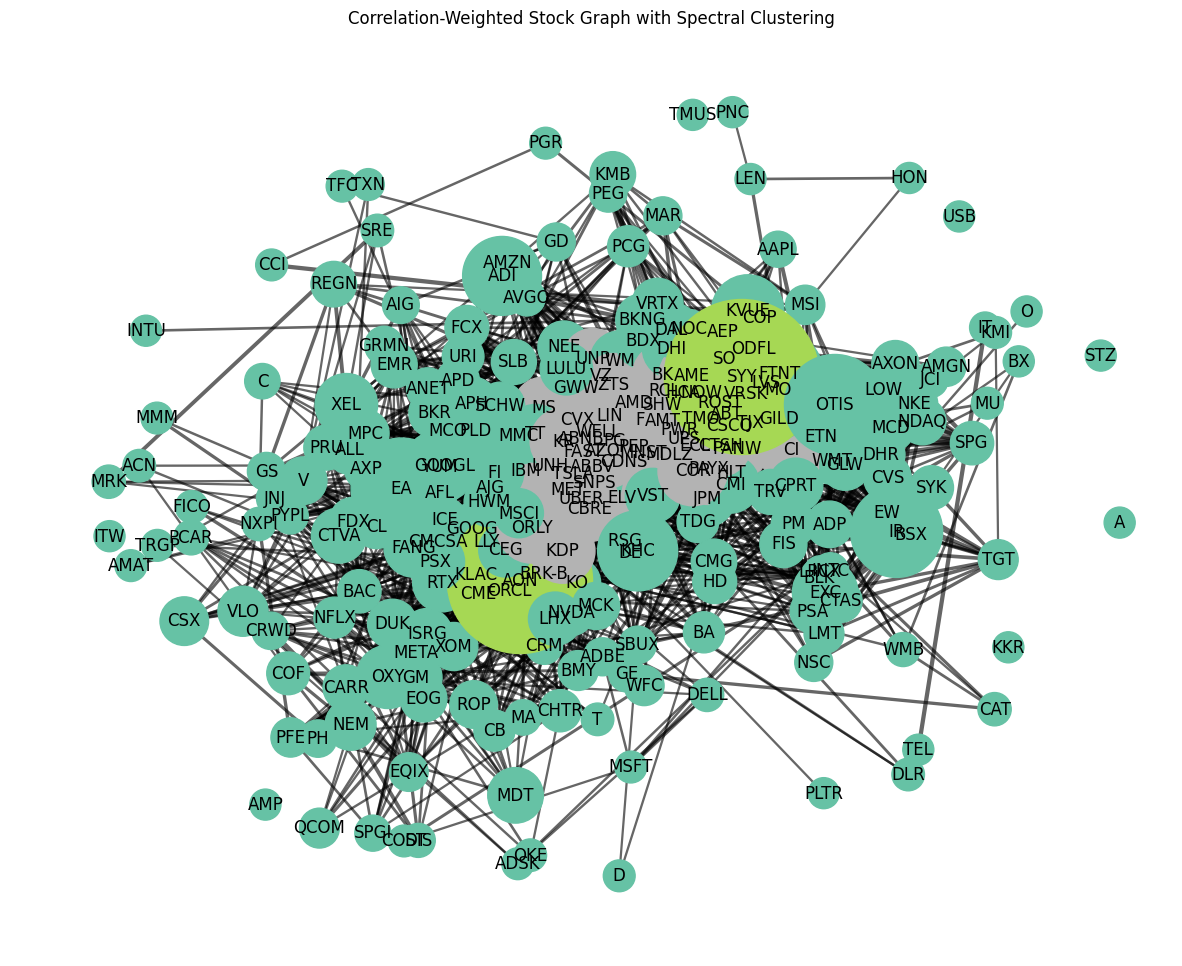

In [205]:
# import matplotlib.pyplot as plt

plt.figure(figsize=(15, 12))
pos = nx.spring_layout(G, seed=42, k=0.5)

node_sizes = 500 + 25 * node_features[:,3]  # loop count
node_colors = labels  # cluster color

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_size=node_sizes, node_color=node_colors, cmap=plt.cm.Set2)

# Draw edges with correlation weight as thickness
edges = G.edges(data=True)
nx.draw_networkx_edges(
    G, pos,
    width=[4 * abs(d['weight']) for (_, _, d) in edges],  # use abs to scale thickness
    alpha=0.6
)

# Draw labels
nx.draw_networkx_labels(G, pos, labels={i: tickers[i] for i in range(len(tickers))})

plt.title("Correlation-Weighted Stock Graph with Spectral Clustering")
plt.axis('off')
plt.show()


In [206]:
from sklearn.decomposition import PCA
# import matplotlib.pyplot as plt

# Reduce features to 2D for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(node_features)

print("Explained variance ratio:", pca.explained_variance_ratio_)


Explained variance ratio: [0.84448122 0.15525936]


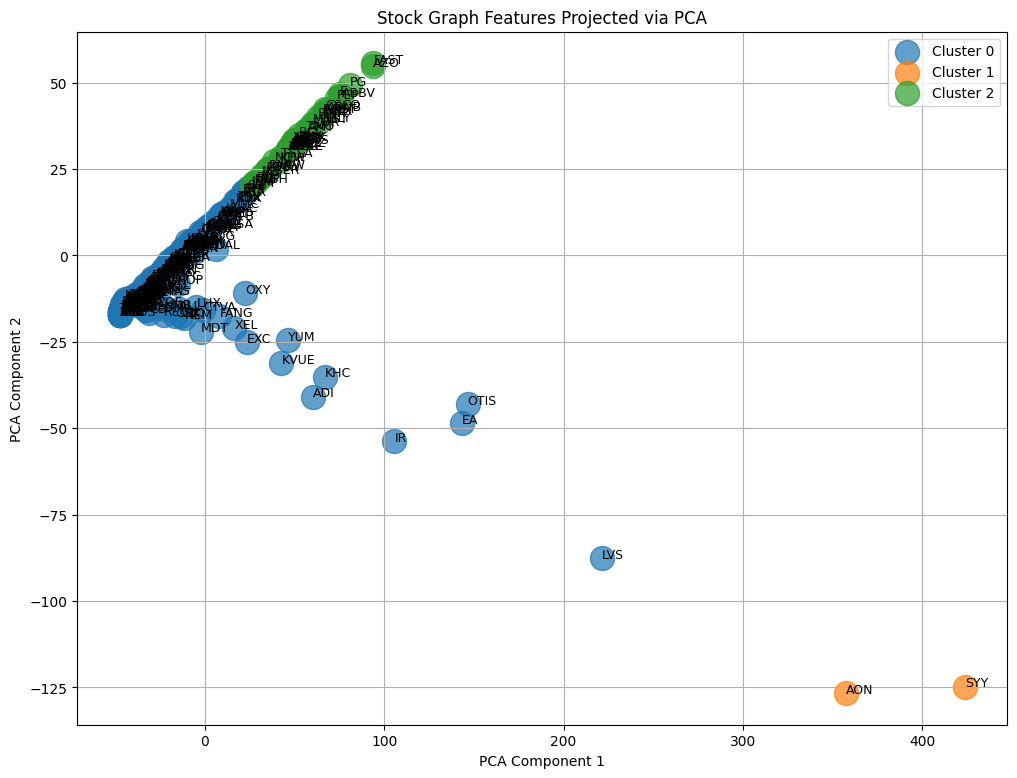

In [207]:
plt.figure(figsize=(12,9))

# Scatter plot, colored by cluster
for cluster_id in np.unique(labels):
    idx = labels == cluster_id
    plt.scatter(
        X_pca[idx,0],
        X_pca[idx,1],
        label=f'Cluster {cluster_id}',
        s=300,
        alpha=0.7
    )

# Annotate with tickers
for i, ticker in enumerate(tickers):
    plt.text(X_pca[i,0]+0.02, X_pca[i,1]+0.02, ticker, fontsize=9)

plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.title("Stock Graph Features Projected via PCA")
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# add topological features from the graph and apply clustering again. does it improve?